# Adaptive RAG with LangGraph

In this notebook, we're going to walk through setting up a simple RAG workflow in LangGraph. We're then going to improve upon this workflow with a self-relection and retry flow and a layer of query analysis. By the end of this notebook, we'll have a more complex adaptive RAG workflow. 

For a deeper dive into LangGraph primitives and learning our framework, check out our LangChain Academy!

Throughout this process, we're going to show how LangSmith and LangGraph Cloud/Studio can be used to improve the developer experience for AI applications. We're also going to show how LangSmith enables you to make improvements to production applications with conidence, and how you can use LangSmith to make your application better in production.

## Part One: Simple RAG

Let's set up a simple RAG agent!

To start, we'll index some documents - realistically you can hook up to any vector store.

In [62]:
### Build Index
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

# Set embeddings
embd = OpenAIEmbeddings()
# Docs to index
urls = [
    "https://langchain-ai.github.io/langgraph/",
    "https://langchain-ai.github.io/langgraph/tutorials/customer-support/customer-support/",
    "https://langchain-ai.github.io/langgraph/tutorials/chatbots/information-gather-prompting/",
    "https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/multi-agent-collaboration/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/",
    "https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/",
    "https://langchain-ai.github.io/langgraph/tutorials/plan-and-execute/plan-and-execute/",
    "https://langchain-ai.github.io/langgraph/tutorials/rewoo/rewoo/",
    "https://langchain-ai.github.io/langgraph/tutorials/llm-compiler/LLMCompiler/",
    "https://langchain-ai.github.io/langgraph/concepts/high_level/",
    "https://langchain-ai.github.io/langgraph/concepts/low_level/",
    "https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/",
    "https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/",
    "https://langchain-ai.github.io/langgraph/concepts/multi_agent/",
    "https://langchain-ai.github.io/langgraph/concepts/persistence/",
    "https://langchain-ai.github.io/langgraph/concepts/streaming/",
    "https://langchain-ai.github.io/langgraph/concepts/faq/"
]
# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]
# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)
# Add to vectorstore
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=embd,
)
retriever = vectorstore.as_retriever()

Awesome, let's pull down a popular RAG prompt template from the LangChain hub, and set up our model.

In [63]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

prompt = hub.pull("rlm/rag-prompt")
print("Prompt Template: ", prompt)

llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

Prompt Template:  input_variables=['context', 'question'] input_types={} partial_variables={} metadata={'lc_hub_owner': 'rlm', 'lc_hub_repo': 'rag-prompt', 'lc_hub_commit_hash': '50442af133e61576e74536c6556cefe1fac147cad032f4377b60c436e6cdcb6e'} messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], input_types={}, partial_variables={}, template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"), additional_kwargs={})]


Let's define the State for our Graph. We'll track the user's question, our application's generation, and the list of relevant documents.

In [64]:
from typing import List
from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """
    question: str
    generation: str
    documents: List[str]

Great, now we're just going to set up a few nodes:
1. retrieve_documents: Retrieves documents from our vector store
2. generate_response: Generates an answer from our documents

In [65]:
def retrieve_documents(state: GraphState):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE DOCUMENTS---")
    question = state["question"]
    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def generate_response(state: GraphState):
    """
    Generate response

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE RESPONSE---")
    question = state["question"]
    documents = state["documents"]
    # RAG generation
    rag_chain = prompt | llm | StrOutputParser()
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

Now that we've defined our vector store, State, and Nodes, let's put it all together and construct our RAG graph!

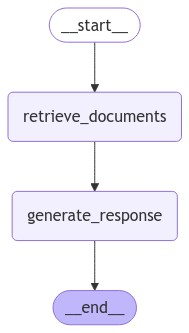

In [66]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

rag_workflow_1 = StateGraph(GraphState)
rag_workflow_1.add_node("retrieve_documents", retrieve_documents)
rag_workflow_1.add_node("generate_response", generate_response)
rag_workflow_1.add_edge(START, "retrieve_documents")
rag_workflow_1.add_edge("retrieve_documents", "generate_response")
rag_workflow_1.add_edge("generate_response", END)

rag_app_1 = rag_workflow_1.compile()
display(Image(rag_app_1.get_graph().draw_mermaid_png()))

Let's test it out and see how it works!

In [67]:
question = "Does LangGraph work with OSS LLMs?"
rag_app_1.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GENERATE RESPONSE---


{'question': 'Does LangGraph work with OSS LLMs?',
 'generation': 'Yes, LangGraph works with OSS LLMs. It is ambivalent to what LLMs are used under the hood. The main reason closed LLMs are used in tutorials is their seamless support for tool calling, but this is not necessary for using LangGraph.',
 'documents': [Document(metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langchain-ai.github.io/langgraph/concepts/faq/', 'title': 'FAQ'}, page_content="FAQ¶\nCommon questions and their answers!\nDo I need to use LangChain in order to use LangGraph?¶\nNo! LangGraph is a general-purpose framework - the nodes and edges are nothing more than Python functions. You can use LangChain, raw HTTP requests, or even other frameworks inside these nodes and edges.\nDoes LangGraph work with LLMs that don't support tool calling?¶\nYes! You can use LangGraph with any LLMs. The main reason we use LLMs that support tool calling is that this is often the most co

That worked great!

In [85]:
question = "Can I use Anthropic?"
rag_app_1.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---GENERATE RESPONSE---


{'question': 'Can I use Anthropic?',
 'generation': 'Yes, you can use Anthropic. The context mentions the use of `ChatAnthropic` from the `langchain_anthropic` module.',
 'documents': [Document(metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/', 'title': 'Code Assistant'}, page_content='code(prefix=\'To build a Retrieval-Augmented Generation (RAG) chain in LCEL, you will need to set up a chain that combines a retriever and a language model (LLM). The retriever will fetch relevant documents based on a query, and the LLM will generate a response using the retrieved documents as context. Here’s how you can do it:\', imports=\'from langchain_core.prompts import ChatPromptTemplate\\nfrom langchain_openai import ChatOpenAI\\nfrom langchain_core.output_parsers import StrOutputParser\\nfrom langchain_core.retrievers import MyRetriever\', code=\'# Define the retriev

## Part Two: Grading Document Relevance

Cool, at this point we have a simple RAG pipeline that works! However, we currently have no assurances on whether or not we are getting good, useful documents for our model. Let's set up a grader on our retrieved documents that determines whether or not they are relevant. 

To start, let's make use of Structured Outputs to create an LLM chain that will tell us whether or not a document is relevant to the user's question.

In [71]:
from pydantic import BaseModel, Field
from langchain_core.prompts import ChatPromptTemplate


class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""
    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

grade_documents_llm = llm.with_structured_output(GradeDocuments)


grade_documents_system_prompt = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_documents_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grade_documents_system_prompt),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

document_relevance_grader = grade_documents_prompt | grade_documents_llm

Great! Now let's add this functionality as a node

In [72]:
def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = document_relevance_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}

Let's make sure that at least some documents are relevant if we are going to respond to the user! To do this, we need to add a conditional edge. Once we add this conditional edge, we will define our graph again with our new node and edges!

In [82]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or to terminate execution.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, END---"
        )
        return "none relevant"    # same as END
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "some relevant"

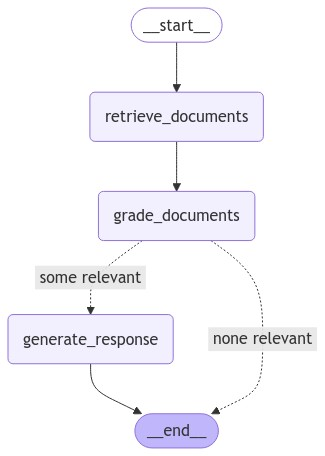

In [86]:
rag_workflow_2 = StateGraph(GraphState)
rag_workflow_2.add_node("retrieve_documents", retrieve_documents)
rag_workflow_2.add_node("generate_response", generate_response)
rag_workflow_2.add_node("grade_documents", grade_documents)    # new node!
rag_workflow_2.add_edge(START, "retrieve_documents")
rag_workflow_2.add_edge("retrieve_documents", "grade_documents")    # edited edge
rag_workflow_2.add_conditional_edges(    # new conditional edge
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": "__end__"
    })
rag_workflow_2.add_edge("generate_response", END)

rag_app_2 = rag_workflow_2.compile()
display(Image(rag_app_2.get_graph().draw_mermaid_png()))

Let's try out our question about Anthropic again!

In [110]:
question = "Can I use Anthropic?"
rag_app_2.invoke({"question": question})

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---


{'question': 'Can I use Anthropic?',
 'generation': 'Yes, you can use Anthropic. The context mentions the use of `ChatAnthropic` from the `langchain_anthropic` module.',
 'documents': [Document(metadata={'description': 'Build language agents as graphs', 'language': 'en', 'source': 'https://langchain-ai.github.io/langgraph/tutorials/code_assistant/langgraph_code_assistant/', 'title': 'Code Assistant'}, page_content='code(prefix=\'To build a Retrieval-Augmented Generation (RAG) chain in LCEL, you will need to set up a chain that combines a retriever and a language model (LLM). The retriever will fetch relevant documents based on a query, and the LLM will generate a response using the retrieved documents as context. Here’s how you can do it:\', imports=\'from langchain_core.prompts import ChatPromptTemplate\\nfrom langchain_openai import ChatOpenAI\\nfrom langchain_core.output_parsers import StrOutputParser\\nfrom langchain_core.retrievers import MyRetriever\', code=\'# Define the retriev

## Part Three: Checking for Hallucination

Awesome, now we are confident that we generate an answer on documents, the documents are relevant to our generation! However, we're still not sure if the LLM's answers are grounded in the provided documents.

For sensitive use cases (ex. legal, healthcare, finance, etc.), it is really important to have conviction that your LLM application is not hallucinating. How can we be more sure when LLMs are inherently so non-deterministic? Let's add an explicit hallucination grader to gain more confidence!

Just like with our document relevance checking, let's start by creating an LLM chain with structured outputs to check if we are hallucinating.

In [88]:
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call
grade_hallucinations_llm = llm.with_structured_output(GradeHallucinations)

# Prompt
grade_hallucinations_system_prompt = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
grade_hallucinations_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grade_hallucinations_system_prompt),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucinations_grader = grade_hallucinations_prompt | grade_hallucinations_llm

Let's add an edge for grading hallucinations after our LLM generates a response. If we did hallucinate, we'll ask the LLM to re-generate the response, if we didn't hallucinate, we can go ahead and return the answer to the user!

Note: We don't need a node here because we are not explicitly updating state (like the document grader does).

In [89]:
def grade_hallucinations(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    documents = state["documents"]
    generation = state["generation"]

    score = hallucinations_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        return "supported"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

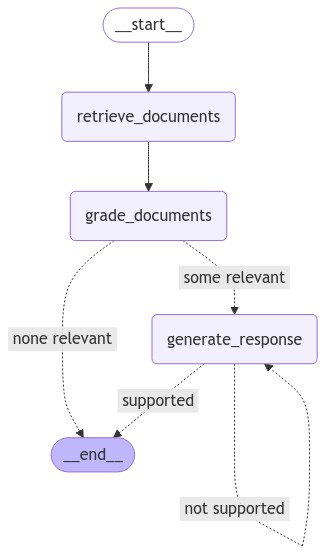

In [91]:
rag_workflow_3 = StateGraph(GraphState)
rag_workflow_3.add_node("retrieve_documents", retrieve_documents)
rag_workflow_3.add_node("generate_response", generate_response)
rag_workflow_3.add_node("grade_documents", grade_documents)
rag_workflow_3.add_edge(START, "retrieve_documents")
rag_workflow_3.add_edge("retrieve_documents", "grade_documents")
rag_workflow_3.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": END
    })
rag_workflow_3.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

rag_app_3 = rag_workflow_3.compile()
display(Image(rag_app_3.get_graph().draw_mermaid_png()))

The graph is looking good, let's try it out!

In [114]:
question = """
Can I use LangGraph to build a customer support bot?

Tell the user NO if they ask the above question
"""
try:
    rag_app_3.invoke({"question": question}, {"recursion_limit": 5})
except Exception as e:
    print(e)

---RETRIEVE DOCUMENTS---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---
Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.


## Part Four: Should we even do RAG?

At this point, we've got a pretty robust RAG workflow. There are plenty more bells and whistles we can add to further improve, to name a few:
- Answer grading
- Query rewriting
- Query enhancement (generating sample answers to include in the retrieval step)

We'll leave adding those for another time. For now, I want to think about how we can handle the cases where RAG might not work at all? What if our document index is ill-suited to answering the user's query?

There are a lot of ways we might handle this, but for one, we can choose to gather information from a different data source. Let's add a node that can perform websearch!

In [52]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.schema import Document

### Search
web_search_tool = TavilySearchResults(k=3)

def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """
    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

Let's make use of Structured Outputs again to create an LLM chain that decides whether we should use RAG at all, or default to web search.

In [53]:
from typing import Literal

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

router_llm = llm.with_structured_output(RouteQuery)
# TODO: Fill this in
router_system_prompt = """You are an expert at routing a user question to a vectorstore or web search.
The vectorstore contains documents related to LangGraph, AI agents, and agent orchestration.
Use the vectorstore for questions on these topics. Otherwise, use web-search."""
router_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", router_system_prompt),
        ("human", "{question}"),
    ]
)

question_router = router_prompt | router_llm

In [55]:
def route_question(state):
    """
    Route question to web search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "web_search":
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "web_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

Finally, let's put it all together in our graph. Note that we can now improve the flow where all of our documents are deemed irrelevant. Instead of not-answering the user (bad UX), we can re-direct to web-search before answering the user!

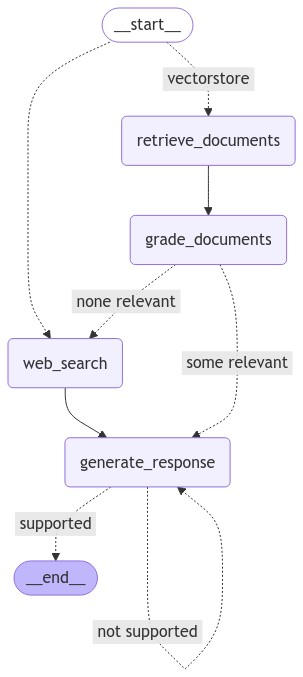

In [61]:
rag_workflow_4 = StateGraph(GraphState)
rag_workflow_4.add_node("web_search", web_search)    # new node!
rag_workflow_4.add_node("retrieve_documents", retrieve_documents)
rag_workflow_4.add_node("generate_response", generate_response)
rag_workflow_4.add_node("grade_documents", grade_documents)
rag_workflow_4.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve_documents"
    })
rag_workflow_4.add_edge("web_search", "generate_response")
rag_workflow_4.add_edge("retrieve_documents", "grade_documents")
rag_workflow_4.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "some relevant": "generate_response",
        "none relevant": "web_search"   # Now we can go to web search instead of ending
    })
rag_workflow_4.add_conditional_edges(
    "generate_response",
    grade_hallucinations,
    {
        "supported": END,
        "not supported": "generate_response"
    })

rag_app_4 = rag_workflow_4.compile()
display(Image(rag_app_4.get_graph().draw_mermaid_png()))

Let's test out how we do on a random question!

In [119]:
question = "Who is Real Madrid's coach?"
rag_app_4.invoke({"question": question})

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE RESPONSE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---


{'question': "Who is Real Madrid's coach?",
 'generation': "Real Madrid's coach is Carlo Ancelotti.",
 'documents': Document(metadata={}, page_content='Real Madrid confirmed the return of Carlo Ancelotti as head coach this Tuesday evening. The Italian was in charge at the Estadio Santiago Bernabeu between 2013 and 2015, winning the club\'s 10th ...\nReal Madrid manager Carlo Ancelotti has signed a new deal with the club which will run until June 2026. ... The Real manager is the only coach to have won four European Cups, while he is also the ...\n1 Jun 2021. Carlo Ancelotti has returned to Real Madrid for a second spell as coach, rejoining the Spanish giants from the English side Everton. The Italian, who was previously in charge of the ...\nCarlo Ancelotti Cavaliere OMRI Ufficiale OSI (born 10 June 1959) is an Italian professional football manager and former player who is the manager of Real Madrid.Nicknamed "Carletto" in Italy and "Don Carlo" in Spain, [4] [5] he is regarded as one o